In [390]:
# from random import Random
from math import log, exp, floor
import matplotlib.pyplot as plt
%matplotlib inline  

"""
|U| = N
|S| = m
|H| = n # Bloom filter table size
n > m
Set 
    - c = n/m
    - k = c*ln(2)
"""
class BloomFilter():

    def __init__(self, m, n=10**6, k=None):

        self.c = n / m 
        if k is None:
            self.k = int(self.c*log(2))
        else:
            self.k = int(k)
        self.n = n
        self.table = [0]*n
        self.random = Random()
        self.bases = [ self.random.random() for _ in range(0, self.k) ]            
    
    def h(self, x, bases):
        return int(floor(self.n * (x*bases - floor(x*bases))))
    
    def hashes(self, x):
        return [ self.h(x, self.bases[k]) for k in range(0, self.k) ] 
                
    def put(self, x):
        for h in self.hashes(x):
            self.table[h] = 1
    
    def get(self, y):
        for h in self.hashes(y):
            if self.table[h] == 0:
                return False
        return True
    
    def getFPR(self, train, test):
        fp = 0
        tn = 0
        for y in test:
            if y not in train:
                if self.get(y):
                    fp += 1
                else: 
                    tn += 1
            
        return 1. * fp / (fp + tn)
    
    def estimateFPR(self):
        return ( 1 - exp(-self.k / self.c) )**self.k

# Inserting the dataset S
def generateData(sample_size=10**4):
    rnd = Random()
    return rnd.sample(xrange(10**10), sample_size)

In [281]:
bloom.hashes(10)

bloom.put(10)
for i in bloom.hashes(10):
    assert i, bloom.table[i] == 1

In [289]:
assert bloom.hashes(10) == bloom.hashes(10)

# Intronduction
Bloom filters is a data structure variant of the hashtable; it supports a super fast insert and super fast lookups. The main strength of bloom-filter is it's space efficiency; it does not store the object, but remember its existance in the set. On the other hand, bloom filter allows mistakes, false positive, and its vanilla implementation  does not support deletion. A bloom-filter is parameterized by 3 main factors the hash function to map the keys to natural number, the number of hash functions k used in the filter, and the size of array n that holds the data. In this report, we are going to explore how can we set those parameters to design an optimal, space and time efficient and robust, bloom filter. In particular, we are going to design a hash function that is deterministic, computationally efficient, and distribute the keys uniformely. Then, we are going to eanalyze the trade-offs between space and correctness.

# Dataset
For this experiment, we are going to generate syntetic data that illustrates the strengths and weaknesses of the bloom filter. We need to create an universe U, a subset S of U that we need to store in the set. U is huge compared to S.
\begin{equation} U \in [0, 10^{10}] \end{equation}
\begin{equation} S \subseteq U and\  |S| = n = 10^4  \end{equation}
In addition, we need to create 2 type of dataset, a training data of size |S| that we are going to insert at the begining of the experiment, and a testing data of the same size to calculate the False Positive Rate. 

# Hash-function

To design an optimal bloom filter, we need to select a function that is deterministic, computationally efficient, and that distribute uniformely the keys. When designing a hash function, we need to carefully think about the data we are going to store. Since we are going to store positive integer, candidates are the modulo function or multiplication method. 

## Multiplication method
Let's define a function h,

\begin{equation*} \forall i \in [1, k], h_i(key) = floor(n * (key * A_i - floor(key - A_i)) ) \end{equation*}

where A is randomly generated from an uniform distribution and n is the size of the table. Note that h always maps any key between 0 and n-1, and that because A is generated randomly, h distribute the element of our collection uniformely.


# Experiment
## Optimal number of hash function k*
The goal of this experiment is to discover the optimal k that yield the least False Positive Rate using the least amount of space possible. For different values of k and n, going to generate 10^4 training data and insert it into our filter. The we are going to generate 10^4 test data and compute the False Positive Rate. Then, we are going to plot the False Positive Rate in function of the size of the hash table. We can observe from the figure below that the optimal number of k is c*ln(2); the False Positive Rate decreases drastically as we increase the table size and decreases to zero much more earlier than any value of k. On the other hand, for one hash table, the FPR platos at 0.1 no matter how much bigger the tables get. For bigger value of k, we eventually reach a FPR equals to 0, but the time complexity increases with more hashes functions. 

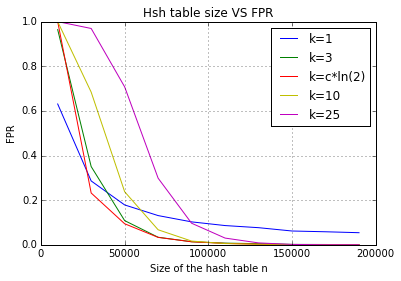

In [389]:
table_size = range(m, 20*m, 2*m)
colors = ['b', 'g', 'r', 'y', 'm']
labels = ['k=1', 'k=3', 'k=c*ln(2)', 'k=10', 'k=25' ]
for i, k in enumerate([ 1, 5, None, 10, 20 ]):
    expected_fpr = []
    fpr = []
    c = []
    for n in table_size:
        # Create instance of bloom filter ...
        bloom = BloomFilter(m, n, k)
        # Populate the hash ... 
        for data in dataset:
            bloom.put(data)

        for data in dataset:
            assert bloom.get(data)
            
        # Get results
        expected_fpr.append(bloom.estimateFPR())
        fpr.append(bloom.getFPR(set(dataset), set(generateData())))
        c.append(bloom.c)
    xaxis = [ t for t in table_size]
    plt.plot(xaxis, fpr, colors[i], label=labels[i])
    plt.legend()
    plt.title('Hash table size VS FPR')
    plt.xlabel('Size of the hash table n')
    plt.ylabel('FPR')
    plt.grid(True)

## Space VS correctness trade-off
To analyze the trade-off between space and correctness, we plot the False Positive Rate VS the size of the table using the optimal number of hash that we discovered above. We observe that the more space we use, the more correct the filter gets until a threshold where the FPR is negligible. 

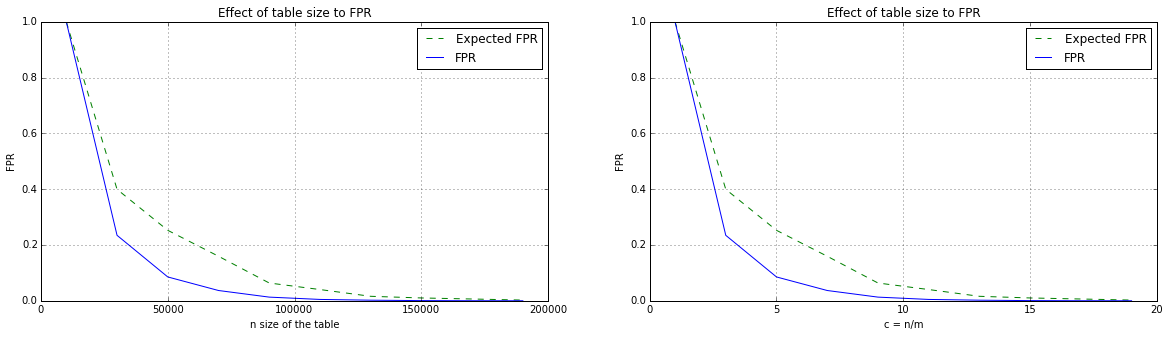

In [407]:
plt.figure(figsize=(20,5))
expected_fpr = []
fpr = []
c = []
table_size = range(m, 20*m, 2*m)
for n in table_size:
    # Create instance of bloom filter
    bloom = BloomFilter(m, n)
    for data in dataset:
        bloom.put(data)
        
    expected_fpr.append(bloom.estimateFPR())
    fpr.append(bloom.getFPR(set(dataset), set(generateData())))
    c.append(bloom.c)

xaxis = [t for t in table_size]
plt.subplot(1, 2, 1)
plt.plot(xaxis, expected_fpr, 'g--', label='Expected FPR')
plt.plot(xaxis, fpr, label='FPR')
plt.grid(True)
plt.title('Effect of table size to FPR')
plt.xlabel('n size of the table')
plt.ylabel('FPR')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(c, expected_fpr, 'g--', label='Expected FPR')
plt.plot(c, fpr, label='FPR')
plt.grid(True)
plt.title('Effect of table size to FPR')
plt.xlabel('c = n/m')
plt.ylabel('FPR')
plt.legend()
plt.show()

## Sanity Check


In [392]:
dataset = generateData()
m = len(dataset)

# Insert in the bloom filter
bloom = BloomFilter(m, 40*m)
for data in dataset:
    bloom.put(data)

# Key distributions ...

# Test wether all False Negative is 0
for data in dataset:
    assert bloom.get(data)

In [386]:
from IPython.display import HTML

HTML('''
<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.input').show();
    } else {
        $('div.input').hide();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>''')